GOAL: data visualization of training camp data

In [1]:
import numpy as np 
import pandas as pd 

from statsmodels.compat import lzip
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from numpy import NaN

# progress bar imports 
import time
from tqdm import tqdm

plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)

<h1> Extract aperiodic data </h1>

In [11]:
d = {}
aper = {}
per = {}


for datapoint in tqdm(range(0, 115)): 
    d["piece{0}".format(datapoint)] = pd.read_excel('Tampa_data_3.0.xlsx', sheet_name = datapoint)

    ######## Extract aperiodic data #########
    start_aper = d["piece{0}".format(datapoint)][d["piece{0}".format(datapoint)].iloc[:, 2] == "0x800A"].index[0] + 1
    end_aper   = d["piece{0}".format(datapoint)][d["piece{0}".format(datapoint)].iloc[:, 2] == "0x8001"].index[0]

    aperiodic = d["piece{0}".format(datapoint)].iloc[start_aper:end_aper, :]

    # Create Multi Header for aperiodic dataframe
    header = [aperiodic.iloc[0].to_numpy(), aperiodic.iloc[1].to_numpy()]
    aperiodic.columns = header
    aperiodic = aperiodic.drop(aperiodic.index[0:3])
    # add margin to dataframe 
    aperiodic['Margin'] = int(d["piece{0}".format(datapoint)].columns[3])
    aper["piece{0}".format(datapoint)] = aperiodic
    
    
    ########### extract periodic data #########
    start_per = d["piece{0}".format(datapoint)][d["piece{0}".format(datapoint)].iloc[:, 1] == "Periodic"].index[0] + 1
    
    periodic = d["piece{0}".format(datapoint)].iloc[start_per:, :32]
    
    # Create Multi Header for periodic dataframe
    header = [periodic.iloc[0].to_numpy(), periodic.iloc[1].to_numpy()]
    periodic.columns = header
    periodic = periodic.drop(periodic.index[0:3])
    
    per["piece{0}".format(datapoint)] = periodic
       

  7%|██▉                                         | 1/15 [00:03<00:43,  3.13s/it]


ValueError: Worksheet index 116 is invalid, 116 worksheets found

In [5]:
aper['piece64']['Drive Start T']

,1,2,3,4,5,6,7,8
97,57,57,58,58,57,52,58,58
98,55,56,55,54,54,53,55,55
99,53,54,51,52,52,51,53,52
100,53,53,52,52,51,52,53,53
101,54,54,51,53,51,52,53,53
...,...,...,...,...,...,...,...,...
246,53,53,52,52,50,49,50,51
247,54,54,52,52,51,51,52,52
248,54,54,52,53,50,50,51,52
249,52,53,52,52,51,49,52,52


Text(0.5, 1.0, '6 strokes over time')

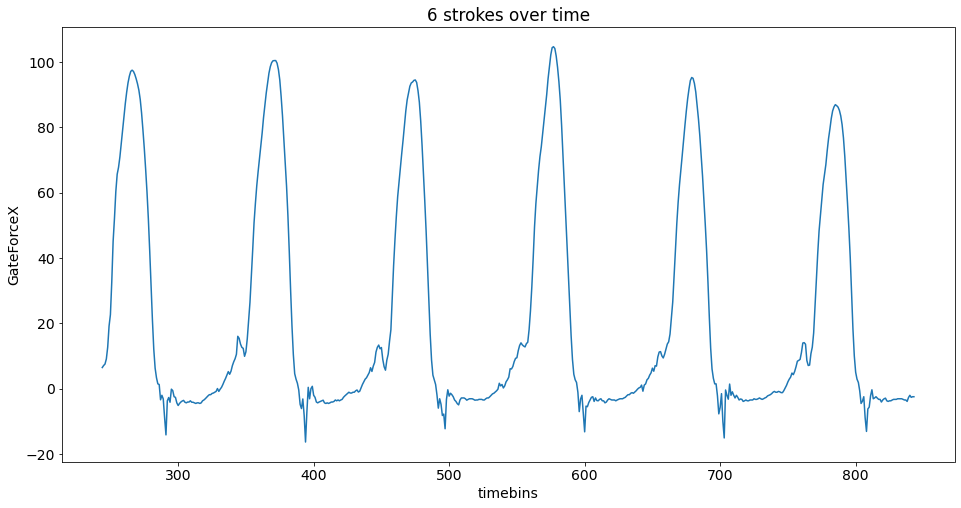

In [4]:
plt.plot(per['piece1'].GateForceX[3][:600])
plt.xlabel('timebins')
plt.ylabel('GateForceX')
plt.title('6 strokes over time')

<h1> Find average Force Curve over all trails </h1>

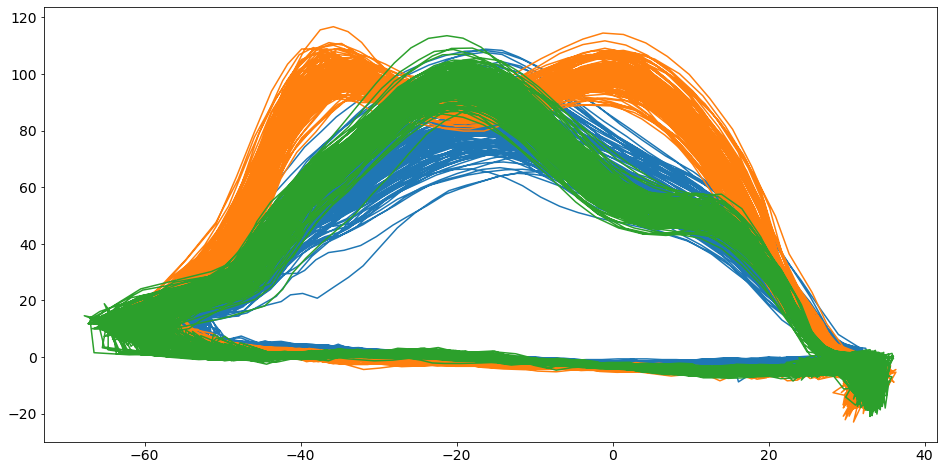

In [8]:
plt.plot( per['piece1'].GateAngle[4], per['piece1'].GateForceX[4])
plt.plot( per['piece1'].GateAngle[5], per['piece1'].GateForceX[5])
plt.plot( per['piece1'].GateAngle[1], per['piece1'].GateForceX[1])

100%|███████████████████████████████████████████| 65/65 [00:01<00:00, 34.68it/s]


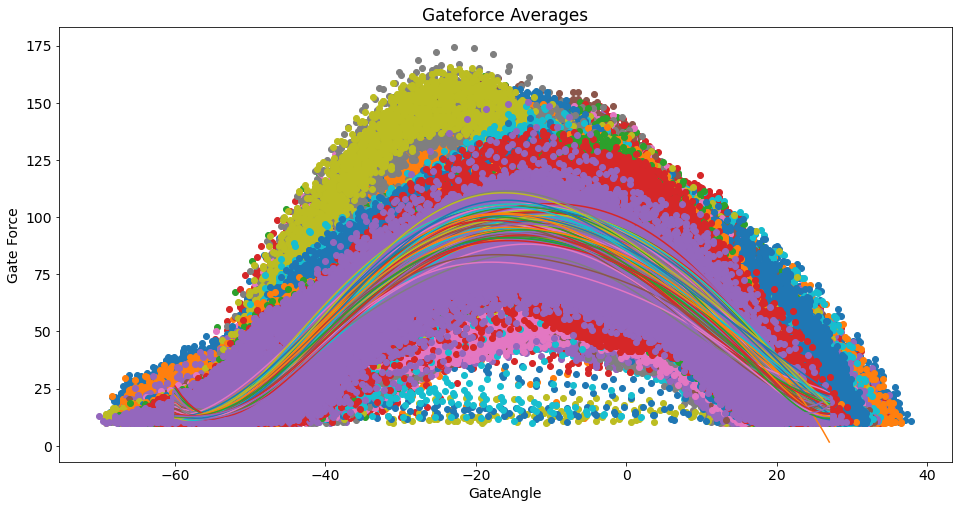

In [285]:
for datapoint in tqdm(range(0, 65)):
    # Gather data 
    idx = np.where(per["piece{0}".format(datapoint)].GateForceX.to_numpy().flatten().astype(float) > 10)
    x = per["piece{0}".format(datapoint)].GateAngle.to_numpy().flatten().astype(float)[idx]
    y = per["piece{0}".format(datapoint)].GateForceX.to_numpy().flatten().astype(float)[idx]

    # run 7-degree polynomial 
    mymodel = np.poly1d(np.polyfit(x, y, 7))
    myline = np.linspace(-60, 27, 100)

    #plot best fit 
    plt.scatter(x, y, label = 'GateForce points, 8 athletes, piece{0}'.format(datapoint))
    plt.plot(myline, mymodel(myline), label = 'average power curve')
    plt.xlabel('GateAngle'); plt.ylabel('Gate Force')
    plt.title('Gateforce Averages')
    



<h1> Clean data </h1>

In [287]:
%%capture 
data = aper["piece0"].mean(axis = 0).to_frame().T

for point in range(1, 65):    
    data = data.append(aper["piece{0}".format(point)].mean(axis = 0).to_frame().T)
    
# remove duplicate columns 
data = data.drop(columns = ['Rower Swivel Power', 'AvgBoatSpeed', 'Dist/Stroke', 'SwivelPower', 'StrokeNumber'])
data = data.reset_index(drop = True)

In [288]:
data.CatchSlip

,1,2,3,4,5,6,7,8
0,15.359589,11.441353,12.103168,9.581764,12.260702,14.933647,17.694777,9.735873
1,15.910714,11.507653,11.926871,9.418367,7.889031,10.378827,18.340986,11.479167
2,14.888393,12.065848,11.171503,8.437872,7.704241,10.321057,18.575893,9.862351
3,11.448785,12.845052,8.991319,7.929688,9.607205,7.566406,15.886719,9.200955
4,12.108305,12.985873,9.812072,7.810360,13.408390,10.256849,17.180651,9.488870
...,...,...,...,...,...,...,...,...
60,11.259334,11.706169,11.740260,10.453328,12.178166,12.446023,12.035714,11.717532
61,10.057328,9.174138,8.591810,12.011207,14.912500,14.421983,13.835776,12.565948
62,10.137003,9.318295,9.339818,12.091887,13.590646,12.682119,14.237169,13.075331
63,10.244473,10.075255,9.163265,12.542942,12.069728,13.391582,12.520408,13.852466


In [289]:
# Compute mean of sublevels 
boat_avg = data.copy() 
boat_avg.MinAngle = boat_avg.MinAngle.mean(axis = 1)
boat_avg.CatchSlip = boat_avg.CatchSlip.mean(axis = 1)
boat_avg.MaxAngle = boat_avg.MaxAngle.mean(axis = 1)
boat_avg.FinishSlip = boat_avg.FinishSlip.mean(axis = 1)
boat_avg['Drive Start T'] = boat_avg['Drive Start T'].mean(axis = 1)
boat_avg['Drive Time'] = boat_avg['Drive Time'].mean(axis = 1)
boat_avg['Recovery Time'] = boat_avg['Recovery Time'].mean(axis = 1)
boat_avg['Angle Max F'] = boat_avg['Angle Max F'].mean(axis = 1)
boat_avg['Angle 0.7 F'] = boat_avg['Angle 0.7 F'].mean(axis = 1)
boat_avg['Work PC Q1'] = boat_avg['Work PC Q1'].mean(axis = 1)
boat_avg['Work PC Q2'] = boat_avg['Work PC Q2'].mean(axis = 1)
boat_avg['Work PC Q3'] = boat_avg['Work PC Q3'].mean(axis = 1)
boat_avg['Work PC Q4'] = boat_avg['Work PC Q4'].mean(axis = 1)
boat_avg['Max Force PC'] = boat_avg['Max Force PC'].mean(axis = 1)

# Remove sublevel duplicates
boat_avg = boat_avg.T.drop_duplicates().T

# Drop sublevel entirely 
boat_avg.columns = boat_avg.columns.get_level_values(0)

# add index to dataframe 
boat_avg = boat_avg.reset_index(drop = True)
boat_avg

,Time,MinAngle,CatchSlip,MaxAngle,FinishSlip,Drive Start T,Drive Time,Recovery Time,Angle Max F,Angle 0.7 F,Work PC Q1,Work PC Q2,Work PC Q3,Work PC Q4,Max Force PC,Rating,Average Power,Margin
0,8.953337e+05,-59.211473,12.888859,32.727861,8.877729,54.452055,0.898784,1.112798,-13.627514,-32.750805,10.837105,37.700239,39.493301,11.969355,49.187030,29.417808,319.321918,-12.0
1,4.339693e+05,-59.872783,12.106452,32.906728,8.795546,54.664966,0.912573,1.113792,-15.569644,-34.809170,11.354188,37.740694,39.260467,11.644652,47.446584,29.363946,338.183673,4.0
2,3.177188e+05,-58.969634,11.628395,32.212612,9.237909,50.799107,0.834508,0.936418,-16.957101,-34.924735,12.520298,38.425250,38.056324,10.998127,45.505493,33.502976,354.476190,2.0
3,1.007475e+06,-57.688694,10.434516,34.632433,9.211589,54.122396,0.901877,1.186566,-9.257312,-32.857787,11.846671,36.752064,39.691333,11.709931,52.401630,28.621528,350.569444,12.0
4,4.407041e+05,-57.293183,11.631421,34.948202,9.538099,53.427226,0.900668,1.158761,-7.784591,-31.198487,11.086064,36.540088,40.503836,11.870012,53.591232,29.270548,342.301370,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,4.387458e+05,-57.097859,11.692066,33.413504,8.546469,53.715097,0.885483,1.033487,-14.466920,-33.421534,11.352841,39.469443,37.827734,11.349982,46.703278,30.373377,358.435065,-8.0
61,2.324290e+05,-58.508190,11.946336,32.226994,9.669666,54.187931,0.939771,1.160121,-14.031901,-35.570342,11.582373,38.535207,39.227715,10.654705,48.813107,28.613793,306.806897,7.0
62,8.793187e+05,-57.769854,11.809034,32.286476,10.670892,53.500828,0.935462,1.088102,-14.190373,-35.834172,12.299645,39.090250,38.669158,9.940948,48.221988,29.784768,299.423841,5.0
63,2.828011e+05,-56.273065,11.732515,32.074777,9.959184,52.437925,0.890150,1.101292,-14.519264,-35.058968,12.526205,39.089389,38.093605,10.290801,47.054263,30.200680,300.176871,20.0


<h1> Add analysis variables </h1>

In [290]:
# variance measures
boat_avg['Drive Start T std'] = data['Drive Start T'].std(axis = 1)
boat_avg['Drive Time std'] = data['Drive Time'].std(axis = 1)
boat_avg['Recovery Time std'] = data['Recovery Time'].std(axis = 1)
boat_avg['Max Force PC std'] = data['Max Force PC'].std(axis = 1)
boat_avg['CatchSlip std'] = data['CatchSlip'].std(axis = 1)

In [291]:
boat_avg

,Time,MinAngle,CatchSlip,MaxAngle,FinishSlip,Drive Start T,Drive Time,Recovery Time,Angle Max F,Angle 0.7 F,...,Work PC Q4,Max Force PC,Rating,Average Power,Margin,Drive Start T std,Drive Time std,Recovery Time std,Max Force PC std,CatchSlip std
0,8.953337e+05,-59.211473,12.888859,32.727861,8.877729,54.452055,0.898784,1.112798,-13.627514,-32.750805,...,11.969355,49.187030,29.417808,319.321918,-12.0,0.678996,0.034670,0.018358,5.291120,2.862763
1,4.339693e+05,-59.872783,12.106452,32.906728,8.795546,54.664966,0.912573,1.113792,-15.569644,-34.809170,...,11.644652,47.446584,29.363946,338.183673,4.0,1.068555,0.039488,0.027263,3.851194,3.425185
2,3.177188e+05,-58.969634,11.628395,32.212612,9.237909,50.799107,0.834508,0.936418,-16.957101,-34.924735,...,10.998127,45.505493,33.502976,354.476190,2.0,0.858994,0.036025,0.013775,5.871411,3.579742
3,1.007475e+06,-57.688694,10.434516,34.632433,9.211589,54.122396,0.901877,1.186566,-9.257312,-32.857787,...,11.709931,52.401630,28.621528,350.569444,12.0,1.802936,0.038117,0.027569,6.718765,2.812094
4,4.407041e+05,-57.293183,11.631421,34.948202,9.538099,53.427226,0.900668,1.158761,-7.784591,-31.198487,...,11.870012,53.591232,29.270548,342.301370,-4.0,2.087431,0.039321,0.027320,6.672171,2.937541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,4.387458e+05,-57.097859,11.692066,33.413504,8.546469,53.715097,0.885483,1.033487,-14.466920,-33.421534,...,11.349982,46.703278,30.373377,358.435065,-8.0,0.849380,0.047614,0.033616,4.117858,0.615019
61,2.324290e+05,-58.508190,11.946336,32.226994,9.669666,54.187931,0.939771,1.160121,-14.031901,-35.570342,...,10.654705,48.813107,28.613793,306.806897,7.0,0.793654,0.038314,0.027424,5.452789,2.431676
62,8.793187e+05,-57.769854,11.809034,32.286476,10.670892,53.500828,0.935462,1.088102,-14.190373,-35.834172,...,9.940948,48.221988,29.784768,299.423841,5.0,0.503435,0.027204,0.028564,5.576351,1.949808
63,2.828011e+05,-56.273065,11.732515,32.074777,9.959184,52.437925,0.890150,1.101292,-14.519264,-35.058968,...,10.290801,47.054263,30.200680,300.176871,20.0,0.546810,0.024479,0.017978,5.494491,1.698731


<h1> General Race Information </h1>

In [292]:
# Extract Crew Information 
crew = d["piece1"].iloc[3:12, 1:8]
crew = crew.rename(columns=crew.iloc[0]).drop(crew.index[0])
crew

,Name,Abbr,ID,First Name,Last Name,Abbreviation,Squad
4,Benz,NaN,NaN,NaN,Benz,NaN,NaN
5,Benn,NaN,NaN,NaN,Benn,NaN,NaN
6,Spin,NaN,NaN,NaN,Spin,NaN,NaN
7,Obra,NaN,NaN,NaN,Obra,NaN,NaN
8,Juel,NaN,NaN,NaN,Juel,NaN,NaN
9,LeRo,NaN,NaN,NaN,LeRo,NaN,NaN
10,Bewi,NaN,NaN,NaN,Bewi,NaN,NaN
11,Quin,NaN,NaN,NaN,Quin,NaN,NaN


In [293]:
# Extract interval statistics 
intervals = d["piece1"].iloc[79:85, 0:7]
intervals = intervals.rename(columns=intervals.iloc[0]).drop(intervals.index[0])
intervals

,Start,End,#,Duration,Distance,Rating,Pace
80,285940,345940,1,00:01:00,0,29.1,---
81,345940,405940,2,00:01:00,0,29.5,---
82,405940,465940,3,00:01:00,0,29.7,---
83,465940,525940,4,00:01:00,0,29.7,---
84,525940,582180,5,00:00:56.200000,0,30,---


In [294]:
# Extract Race Comments 
comments = d["piece1"].iloc[1, 7]
comments

"4x 5' @SR28/30/30/32"

<h1> Aperiodic Data Visualization</h1>

<AxesSubplot:>

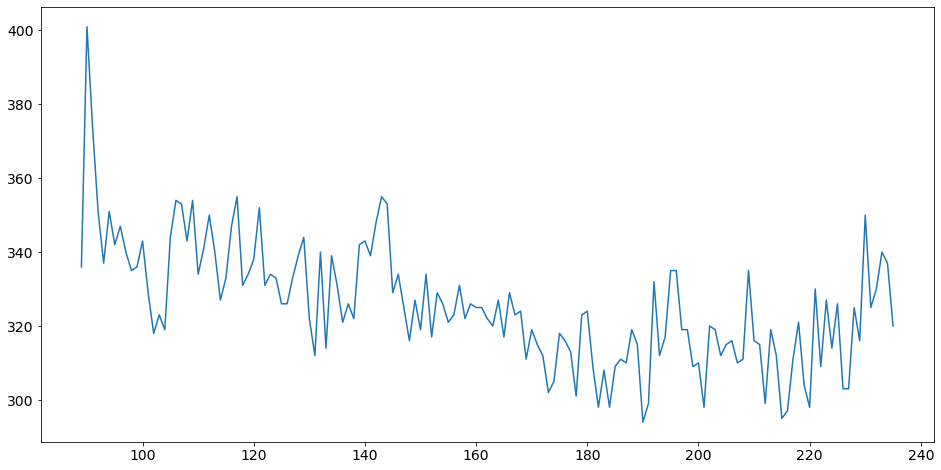

In [295]:
aper["piece1"]['SwivelPower'][2].plot()

<h1> Regression (features vs outcome) </h1>

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


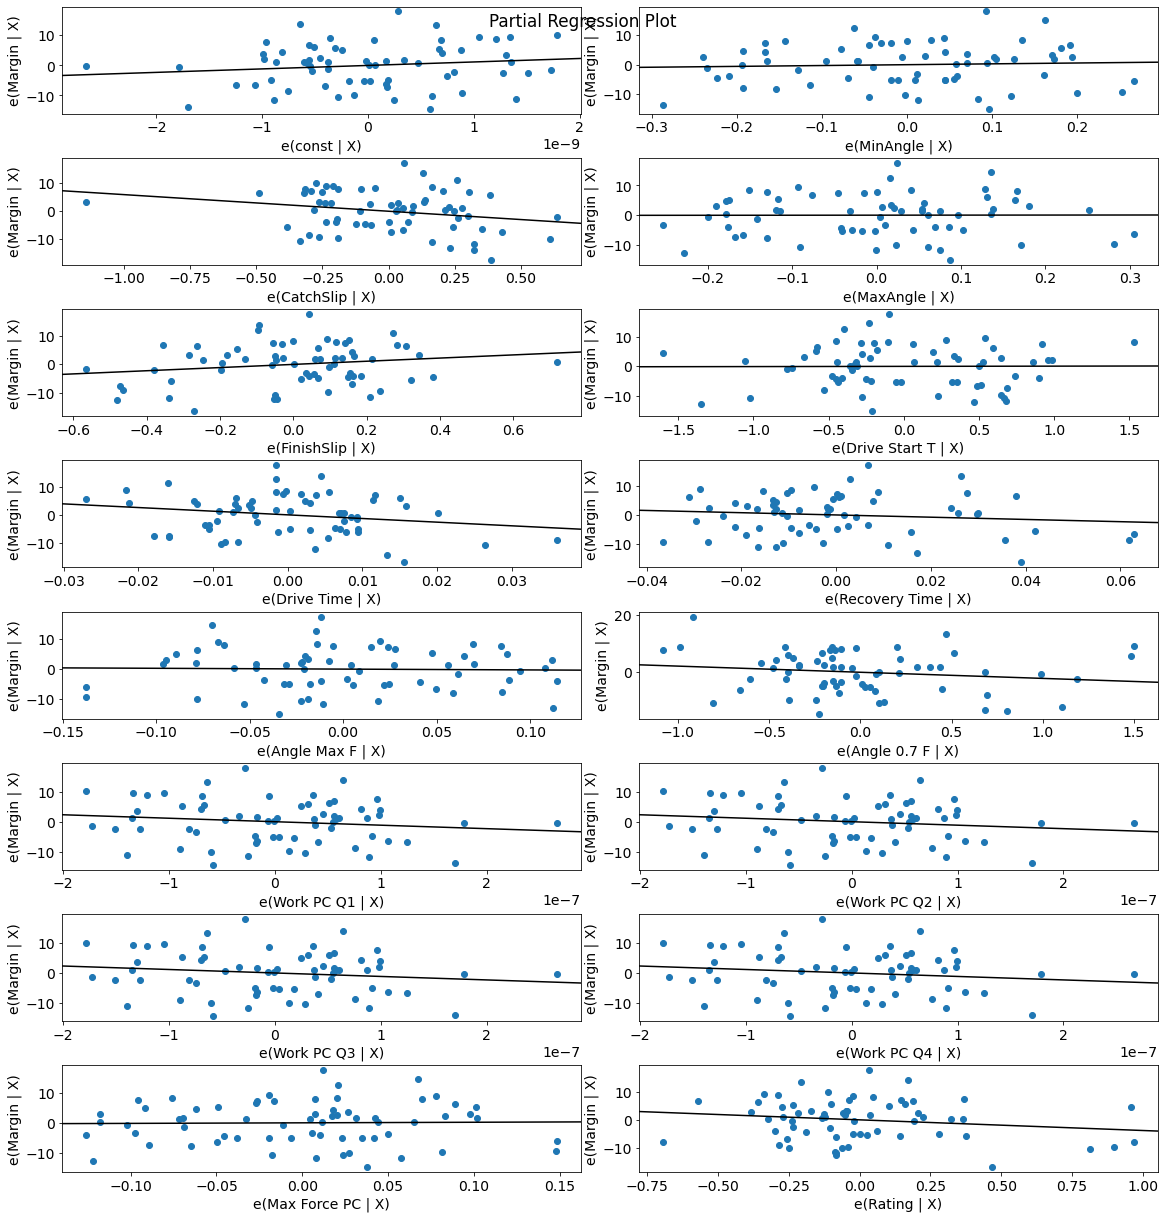

In [296]:
# partial regression plot 
x =  boat_avg.iloc[:, 1:16]
x = sm.add_constant(x)
y = boat_avg.Margin

model = sm.OLS(y, x, missing='drop').fit()

fig = sm.graphics.plot_partregress_grid(model)
fig.set_figheight(17)
fig.tight_layout(pad=0.0)

In [297]:
# Run regression with selected variables
x =  boat_avg.iloc[:, [2,3,6,8,9,10,16,18,21,22]]
x = sm.add_constant(x)
y = boat_avg.Margin

model = sm.OLS(y, x, missing='drop').fit()
results = model
p = model.params
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Margin   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     1.849
Date:                Sun, 05 Mar 2023   Prob (F-statistic):             0.0737
Time:                        17:29:54   Log-Likelihood:                -218.33
No. Observations:                  65   AIC:                             458.7
Df Residuals:                      54   BIC:                             482.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                71.4735    113.05

<h1> Lasso Regression </h1>

In [298]:
lasso = sm.OLS(y, x, missing='drop').fit_regularized()
results = lasso
p = lasso.params
print(p)

const               -12.505769
CatchSlip            -0.244582
MaxAngle              0.125232
Drive Time           -0.801801
Angle Max F          -0.095469
Angle 0.7 F           0.010554
Work PC Q1           -0.218241
Average Power         0.004536
Drive Start T std    -1.215998
Max Force PC std      1.320834
CatchSlip std         2.399287
dtype: float64


<h1> Correlation Analysis </h1> 

In [304]:
corr = boat_avg.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

/var/folders/31/fstssryx6fz79_8yk16n79tw0000gn/T/ipykernel_89964/2146308696.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(3)


,Time,MinAngle,CatchSlip,MaxAngle,FinishSlip,Drive Start T,Drive Time,Recovery Time,Angle Max F,Angle 0.7 F,Work PC Q1,Work PC Q2,Work PC Q3,Work PC Q4,Max Force PC,Rating,Average Power,Margin,Drive Start T std,Drive Time std,Recovery Time std,Max Force PC std,CatchSlip std
Time,1.000,-0.040,-0.008,0.153,-0.105,-0.244,-0.178,-0.248,0.150,0.252,-0.068,-0.262,0.152,0.183,0.131,0.258,0.336,0.050,0.180,-0.105,0.184,0.062,0.250
MinAngle,-0.040,1.000,-0.573,-0.389,0.373,-0.395,-0.313,-0.288,-0.086,-0.028,0.797,0.416,-0.624,-0.666,-0.351,0.328,-0.353,-0.055,0.016,-0.122,0.017,0.091,0.103
CatchSlip,-0.008,-0.573,1.000,0.138,0.047,0.138,0.236,-0.002,0.284,0.259,-0.786,-0.059,0.668,0.228,0.471,-0.152,-0.048,-0.188,0.087,0.025,-0.046,-0.423,-0.100
MaxAngle,0.153,-0.389,0.138,1.000,0.207,0.058,0.104,0.096,0.508,0.340,-0.328,-0.290,0.365,0.278,0.435,-0.142,0.452,0.161,0.443,0.132,0.069,0.304,-0.112
FinishSlip,-0.105,0.373,0.047,0.207,1.000,-0.372,-0.079,-0.336,0.137,0.020,0.330,0.534,-0.169,-0.757,-0.008,0.243,-0.272,-0.047,0.286,-0.202,-0.109,0.102,0.028
Drive Start T,-0.244,-0.395,0.138,0.058,-0.372,1.000,0.792,0.886,-0.042,-0.175,-0.359,-0.118,0.215,0.302,0.072,-0.931,-0.394,0.104,-0.179,0.469,0.115,-0.011,-0.345
Drive Time,-0.178,-0.313,0.236,0.104,-0.079,0.792,1.000,0.718,0.110,-0.085,-0.359,-0.059,0.316,0.127,0.220,-0.853,-0.490,0.015,-0.039,0.435,0.083,-0.021,-0.289
Recovery Time,-0.248,-0.288,-0.002,0.096,-0.336,0.886,0.718,1.000,0.018,-0.056,-0.297,-0.197,0.219,0.307,0.096,-0.945,-0.370,0.177,-0.032,0.465,0.108,0.130,-0.205
Angle Max F,0.150,-0.086,0.284,0.508,0.137,-0.042,0.110,0.018,1.000,0.601,-0.340,-0.482,0.685,0.133,0.944,-0.071,0.091,-0.081,0.394,-0.057,-0.178,-0.126,-0.009
Angle 0.7 F,0.252,-0.028,0.259,0.340,0.020,-0.175,-0.085,-0.056,0.601,1.000,-0.421,-0.261,0.511,0.192,0.545,0.066,0.326,-0.111,0.411,0.024,-0.040,0.019,0.155


<h1> Outlier Analaysis </h1> 

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

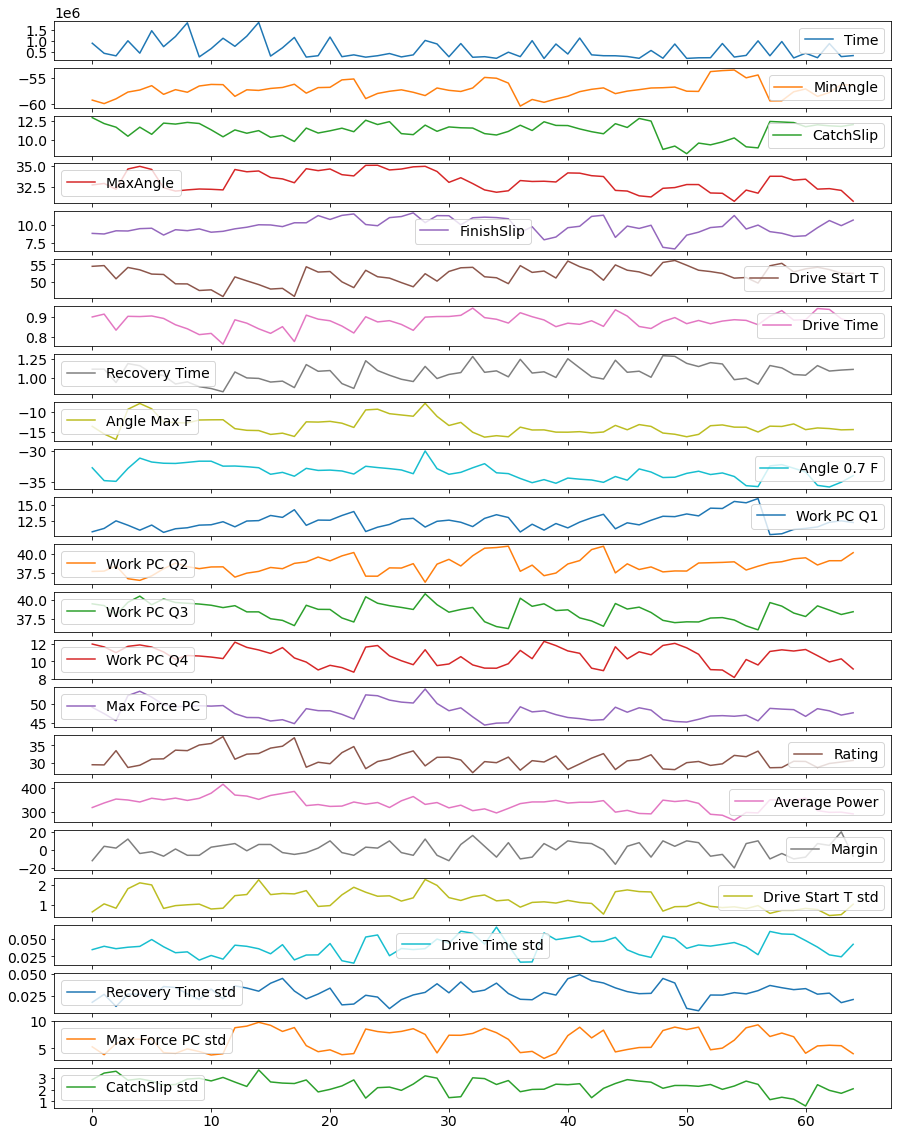

In [306]:
boat_avg.plot(subplots = True, figsize = (15,20))

<h1> MODEL #1: TREE </h1> 

In [307]:
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# create an xgboost regression model
model = XGBRegressor(n_estimators=1000, max_depth=12, eta=0.1, subsample=0.7, colsample_bytree=0.8)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=7, random_state=1)
# evaluate model
scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 7.016 (1.723)


<h1> MODEL #2 NEURAL NETWORK </h1> 

In [308]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(6, 3), random_state=1)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=7, random_state=1)
# evaluate model
scores = cross_val_score(clf, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 7.020 (1.663)
